In [95]:
import numpy as np 
import pandas as pd 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.weightstats import ztest 
from statsmodels.tsa.stattools import adfuller
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMRegressor

import seaborn as sns
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action = 'ignore') 
pd.options.display.max_columns = 999  

In [96]:
!pip install koreanize_matplotlib

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [97]:
import koreanize_matplotlib

In [98]:
train = pd.read_csv('train.csv', encoding='CP949')
test = pd.read_csv('test.csv', encoding='CP949')

In [99]:
print(train.info());print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122400 entries, 0 to 122399
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   num         122400 non-null  int64  
 1   date_time   122400 non-null  object 
 2   전력사용량(kWh)  122400 non-null  float64
 3   기온(°C)      122400 non-null  float64
 4   풍속(m/s)     122400 non-null  float64
 5   습도(%)       122400 non-null  float64
 6   강수량(mm)     122400 non-null  float64
 7   일조(hr)      122400 non-null  float64
 8   비전기냉방설비운영   122400 non-null  float64
 9   태양광보유       122400 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 9.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10080 entries, 0 to 10079
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num           10080 non-null  int64  
 1   date_time     10080 non-null  object 
 2   기온(°C)        3360 non-null   flo

# 1. 결측치 처리

## 1-1. test 데이터셋의 비전기냉방설비운영, 태양광보유 결측치 처리

In [100]:
## test 데이터셋의 비전기냉방설비운영, 태양광보유 결측치 처리
## 건물별 비전기냉방설비운영, 태양광보유 여부를 통해
## test 데이터셋의 비전기냉방설비운영, 태양광보유 결측치를 처리한다.

In [101]:
group = test.groupby(['강수량(mm, 6시간)'])

In [102]:
test[['num', 'date_time', '강수량(mm, 6시간)']].iloc[1092:1105]

,num,date_time,"강수량(mm, 6시간)"
1092,7,2020-08-28 12,0.2
1093,7,2020-08-28 13,NaN
1094,7,2020-08-28 14,NaN
1095,7,2020-08-28 15,NaN
1096,7,2020-08-28 16,NaN
1097,7,2020-08-28 17,NaN
1098,7,2020-08-28 18,5.8
1099,7,2020-08-28 19,NaN
1100,7,2020-08-28 20,NaN
1101,7,2020-08-28 21,NaN


In [103]:
mapping = {}

for i in train['num'].unique():
    mapping[i] = train.loc[train['num'] == i, '비전기냉방설비운영'].unique()[0], train.loc[train['num'] == i, '태양광보유'].unique()[0]
    
test['비전기냉방설비운영'] = test['num'].apply(lambda x: mapping[x][0])
test['태양광보유'] = test['num'].apply(lambda x: mapping[x][1])
test

,num,date_time,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유
0,1,2020-08-25 00,27.8,1.5,74.0,0.0,0.0,0.0,0.0
1,1,2020-08-25 01,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2,1,2020-08-25 02,NaN,NaN,NaN,NaN,NaN,0.0,0.0
3,1,2020-08-25 03,27.3,1.1,78.0,NaN,0.0,0.0,0.0
4,1,2020-08-25 04,NaN,NaN,NaN,NaN,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...
10075,60,2020-08-31 19,NaN,NaN,NaN,NaN,NaN,1.0,1.0
10076,60,2020-08-31 20,NaN,NaN,NaN,NaN,NaN,1.0,1.0
10077,60,2020-08-31 21,27.9,4.1,68.0,NaN,0.0,1.0,1.0
10078,60,2020-08-31 22,NaN,NaN,NaN,NaN,NaN,1.0,1.0


## 1-2. test데이터셋 기상 결측치 보간

In [104]:
## test 데이터셋의 기상정보 결측치 처리
## train은 1시간 단위로 기상정보가 채워져
## test는 3시간/6시간 단위 예측 데이터이므로 중간중간 결측치생김
## 기상정보의 결측치에 대해서는 보간법 사용

In [105]:
test = test.interpolate(method='linear')
test

,num,date_time,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유
0,1,2020-08-25 00,27.800000,1.500000,74.000000,0.0,0.000000,0.0,0.0
1,1,2020-08-25 01,27.633333,1.366667,75.333333,0.0,0.000000,0.0,0.0
2,1,2020-08-25 02,27.466667,1.233333,76.666667,0.0,0.000000,0.0,0.0
3,1,2020-08-25 03,27.300000,1.100000,78.000000,0.0,0.000000,0.0,0.0
4,1,2020-08-25 04,26.900000,1.166667,79.666667,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...
10075,60,2020-08-31 19,28.633333,3.566667,66.000000,0.0,0.533333,1.0,1.0
10076,60,2020-08-31 20,28.266667,3.833333,67.000000,0.0,0.266667,1.0,1.0
10077,60,2020-08-31 21,27.900000,4.100000,68.000000,0.0,0.000000,1.0,1.0
10078,60,2020-08-31 22,27.900000,4.100000,68.000000,0.0,0.000000,1.0,1.0


In [106]:
test[['num', 'date_time', '강수량(mm, 6시간)']].iloc[1092:1105]

,num,date_time,"강수량(mm, 6시간)"
1092,7,2020-08-28 12,0.200000
1093,7,2020-08-28 13,1.133333
1094,7,2020-08-28 14,2.066667
1095,7,2020-08-28 15,3.000000
1096,7,2020-08-28 16,3.933333
1097,7,2020-08-28 17,4.866667
1098,7,2020-08-28 18,5.800000
1099,7,2020-08-28 19,4.833333
1100,7,2020-08-28 20,3.866667
1101,7,2020-08-28 21,2.900000


# 2. EDA

## 2-1. date_time칼럼으로 날짜변수 생성

In [107]:
def make_time(df):
    df['date_time'] = df['date_time'].astype('datetime64')
    df['날짜'] = df['date_time'].dt.date
    df['월'] = df['date_time'].dt.month
    df['주'] = df['date_time'].dt.week
    df['일'] = df['date_time'].dt.day
    df['시각'] = df['date_time'].dt.hour
    df['요일'] = df['date_time'].dt.weekday
    df['요일'] = df['요일'] + 1
    df['주말'] = df['요일'].isin([6,7]).astype(int)
    df['월별주수'] = np.ceil(df['일']/7).astype(int)
    return df

train = make_time(train)
test = make_time(test)

In [108]:
test

,num,date_time,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유,날짜,월,주,일,시각,요일,주말,월별주수
0,1,2020-08-25 00:00:00,27.800000,1.500000,74.000000,0.0,0.000000,0.0,0.0,2020-08-25,8,35,25,0,2,0,4
1,1,2020-08-25 01:00:00,27.633333,1.366667,75.333333,0.0,0.000000,0.0,0.0,2020-08-25,8,35,25,1,2,0,4
2,1,2020-08-25 02:00:00,27.466667,1.233333,76.666667,0.0,0.000000,0.0,0.0,2020-08-25,8,35,25,2,2,0,4
3,1,2020-08-25 03:00:00,27.300000,1.100000,78.000000,0.0,0.000000,0.0,0.0,2020-08-25,8,35,25,3,2,0,4
4,1,2020-08-25 04:00:00,26.900000,1.166667,79.666667,0.0,0.000000,0.0,0.0,2020-08-25,8,35,25,4,2,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10075,60,2020-08-31 19:00:00,28.633333,3.566667,66.000000,0.0,0.533333,1.0,1.0,2020-08-31,8,36,31,19,1,0,5
10076,60,2020-08-31 20:00:00,28.266667,3.833333,67.000000,0.0,0.266667,1.0,1.0,2020-08-31,8,36,31,20,1,0,5
10077,60,2020-08-31 21:00:00,27.900000,4.100000,68.000000,0.0,0.000000,1.0,1.0,2020-08-31,8,36,31,21,1,0,5
10078,60,2020-08-31 22:00:00,27.900000,4.100000,68.000000,0.0,0.000000,1.0,1.0,2020-08-31,8,36,31,22,1,0,5


In [109]:
def resamples(ts_data, col_nm, time_span, func_list):
    
    df_summary = pd.DataFrame() # blank DataFrame to store results

    # resampler with column name by time span (group by)
    resampler = ts_data[col_nm].resample(time_span)

    # aggregation functions with suffix name
    if 'first' in func_list:
        df_summary[col_nm + '_' + time_span + '_first'] = resampler.first()

    if 'last' in func_list:
        df_summary[col_nm + '_' + time_span + '_last'] = resampler.last()

    if 'sum' in func_list:
        df_summary[col_nm + '_' + time_span + '_sum'] = resampler.sum()

    if 'cumsum' in func_list:
        df_summary[col_nm + '_' + time_span + '_cumsum'] = resampler.sum().cumsum()

    if 'min' in func_list:
        df_summary[col_nm + '_' + time_span + '_min'] = resampler.min()

    if 'max' in func_list:
        df_summary[col_nm + '_' + time_span + '_max'] = resampler.max()

    if 'mean' in func_list:
        df_summary[col_nm + '_' + time_span + '_mean'] = resampler.mean()

    if 'median' in func_list:
        df_summary[col_nm + '_' + time_span + '_median'] = resampler.median()

    if 'range' in func_list:
        df_summary[col_nm + '_' + time_span + '_range'] = resampler.max() - resampler.min()

    if 'var' in func_list:
        df_summary[col_nm + '_' + time_span + '_var'] = resampler.var() # sample variance

    if 'stddev' in func_list:
        df_summary[col_nm + '_' + time_span + '_stddev'] = np.sqrt(resampler.var())

    return df_summary

## 6월 6일은 현충일, 8월 15일은 광복절, 8월 17일은 임시공휴일 
주말에 포함시키 
6월 6일과 8월 15일은 이미 주말에 포함되어있음

In [110]:
train.loc[(train.월 == 8) & (train.월 == 17), '주말'] = 1    

In [111]:
eda_df = train.copy()

In [112]:
eda_df.index = pd.to_datetime(eda_df['date_time'])

In [113]:
func_list = ['mean', 'min', 'max', 'var', 'stddev']
rs = resamples(eda_df, '전력사용량(kWh)', '1D', func_list)
rs = rs.merge(eda_df[['주말']], left_index=True, right_index=True)

In [114]:
# fig = plt.figure(figsize = (20, 240))
# for num in eda_df['num'].unique():
#     df = eda_df[eda_df.num == num]
#     plt.subplot(60, 1, num)
#     sns.lineplot(data = df, x = 'date_time', y= '전력사용량(kWh)', linewidth = 0.3)
#     plt.title(f'building {num}')
#     plt.yticks([])
#     plt.subplots_adjust(hspace = 1)

In [115]:
def hour_binning(x):
    if x in [9, 10, 11, 12, 13, 14, 15, 16, 17, 18]:
        return '활동' # 활동 시간대
    elif x in [6, 7, 8]: 
        return '아침' # 아침 시간대
    elif x in [19, 20, 21, 22]:
        return '저녁' # 저녁 시간대 
    elif x in [23, 0, 1, 2, 3, 4, 5]:
        return '취침' #  취침 시간대 
    
    
# 시각을 재구간화한 시간대 컬럼 추가
eda_df['시간대'] = eda_df['시각'].apply(hour_binning)
test['시간대'] = test['시각'].apply(hour_binning)

In [116]:
eda_df.columns

Index(['num', 'date_time', '전력사용량(kWh)', '기온(°C)', '풍속(m/s)', '습도(%)',
       '강수량(mm)', '일조(hr)', '비전기냉방설비운영', '태양광보유', '날짜', '월', '주', '일', '시각',
       '요일', '주말', '월별주수', '시간대'],
      dtype='object')

In [117]:
# 불쾌 지수
def make_thi(df):
    df['불쾌지수'] = 9/5 * df['기온(°C)'] - 0.55 * (1-df['습도(%)']/100) * (9/5 * df['기온(°C)'] - 26) + 32
    return df

eda_df = make_thi(eda_df)
test = make_thi(test)

In [118]:
# 체감 온도
def make_feeltemp(df):
    df['체감온도'] = 13.12 + 0.6215 * df['기온(°C)'] - 11.37 * ((df['풍속(m/s)']/1000) ** 0.16) + 0.3965 * ((df['풍속(m/s)']/1000) ** 0.16) * df['기온(°C)']
    return df

eda_df = make_feeltemp(eda_df)
test = make_feeltemp(test)

In [119]:
test

,num,date_time,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유,날짜,월,주,일,시각,요일,주말,월별주수,시간대,불쾌지수,체감온도
0,1,2020-08-25 00:00:00,27.800000,1.500000,74.000000,0.0,0.000000,0.0,0.0,2020-08-25,8,35,25,0,2,0,4,취침,78.602280,30.274990
1,1,2020-08-25 01:00:00,27.633333,1.366667,75.333333,0.0,0.000000,0.0,0.0,2020-08-25,8,35,25,1,2,0,4,취침,78.519273,30.150217
2,1,2020-08-25 02:00:00,27.466667,1.233333,76.666667,0.0,0.000000,0.0,0.0,2020-08-25,8,35,25,2,2,0,4,취침,78.431867,30.026349
3,1,2020-08-25 03:00:00,27.300000,1.100000,78.000000,0.0,0.000000,0.0,0.0,2020-08-25,8,35,25,3,2,0,4,취침,78.340060,29.903525
4,1,2020-08-25 04:00:00,26.900000,1.166667,79.666667,0.0,0.000000,0.0,0.0,2020-08-25,8,35,25,4,2,0,4,취침,77.912697,29.599362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10075,60,2020-08-31 19:00:00,28.633333,3.566667,66.000000,0.0,0.533333,1.0,1.0,2020-08-31,8,36,31,19,1,0,5,저녁,78.764020,30.908765
10076,60,2020-08-31 20:00:00,28.266667,3.833333,67.000000,0.0,0.266667,1.0,1.0,2020-08-31,8,36,31,20,1,0,5,저녁,78.364280,30.621114
10077,60,2020-08-31 21:00:00,27.900000,4.100000,68.000000,0.0,0.000000,1.0,1.0,2020-08-31,8,36,31,21,1,0,5,저녁,77.957280,30.332176
10078,60,2020-08-31 22:00:00,27.900000,4.100000,68.000000,0.0,0.000000,1.0,1.0,2020-08-31,8,36,31,22,1,0,5,저녁,77.957280,30.332176


In [120]:
# 3-5. 불쾌지수, 체감온도를 구간화
# 기상청의 불쾌지수 단계별 설명 및 주의사항을 참고하여 비닝하였다. (참고 : https://www.kma.go.kr/HELP/basic/help_01_05.jsp)

# def binning_THI(x:float)->int:
#     if x >= 80:
#         return 1
#     elif (x >= 75) & (x < 80) :
#         return 2
#     elif (x >= 68) & (x < 75) :
#         return 3
#     elif x < 68:
#         return 4
    
# train['불쾌지수구간'] = train['불쾌지수'].apply(binning_THI)
# test['불쾌지수구간'] = test['불쾌지수'].apply(binning_THI)
# 기상청의 체감온도 단계별 설명 및 주의사항을 참고하여 비닝하였다. (참고 : https://www.weather.go.kr/weather/lifenindustry/li_asset/HELP/basic/JISU_HELP_v1.1.pdf)

# def binning_WCT(x:float)->int:
#     if x >= 37:
#         return 1
#     elif (x >= 34) & (x < 37):
#         return 2
#     elif (x >= 31) & (x < 34):
#         return 3
#     elif (x >= 29) & (x < 31):
#         return 4
#     elif x < 29:
#         return 5
    
# train['체감온도구간'] = train['체감온도'].apply(binning_WCT)
# test['체감온도구간'] = test['체감온도'].apply(binning_WCT)

## 2-2 이상치 처리하는 코드 모음

In [121]:
## 이상치를 99백분위수와 1백분위수로 대체

In [122]:
building_nums = eda_df['num'].unique()

for num in building_nums:
    quantile_99 = eda_df.loc[eda_df['num']==num, '전력사용량(kWh)'].quantile(0.99)
    quantile_1 = eda_df.loc[eda_df['num']==num, '전력사용량(kWh)'].quantile(0.01)

    eda_df.loc[(eda_df['num']==num) & (eda_df['전력사용량(kWh)'] > quantile_99), '전력사용량(kWh)'] = quantile_99
    eda_df.loc[(eda_df['num']==num) & (eda_df['전력사용량(kWh)'] < quantile_1), '전력사용량(kWh)'] = quantile_1

In [125]:
num = 3
eda_df['날짜'] = pd.to_datetime(eda_df['날짜'])

start_date = pd.to_datetime('2020-08-06')
end_date = pd.to_datetime('2020-08-08')

filtered_df = eda_df[(eda_df['날짜'] >= start_date) & (eda_df['날짜'] <= end_date)]

quantile_99 = filtered_df.loc[filtered_df['num'] == num, '전력사용량(kWh)'].quantile(0.99)
quantile_1 = filtered_df.loc[filtered_df['num'] == num, '전력사용량(kWh)'].quantile(0.01)

eda_df.loc[(eda_df['num'] == num) & (eda_df['전력사용량(kWh)'] > quantile_99), '전력사용량(kWh)'] = quantile_99
eda_df.loc[(eda_df['num'] == num) & (eda_df['전력사용량(kWh)'] < quantile_1), '전력사용량(kWh)'] = quantile_1

In [126]:
num = 9
eda_df['날짜'] = pd.to_datetime(eda_df['날짜'])

start_date = pd.to_datetime('2020-06-02')
end_date = pd.to_datetime('2020-06-04')

filtered_df = eda_df[(eda_df['날짜'] >= start_date) & (eda_df['날짜'] <= end_date)]

quantile_99 = filtered_df.loc[filtered_df['num'] == num, '전력사용량(kWh)'].quantile(0.99)
quantile_1 = filtered_df.loc[filtered_df['num'] == num, '전력사용량(kWh)'].quantile(0.01)

eda_df.loc[(eda_df['num'] == num) & (eda_df['전력사용량(kWh)'] > quantile_99), '전력사용량(kWh)'] = quantile_99
eda_df.loc[(eda_df['num'] == num) & (eda_df['전력사용량(kWh)'] < quantile_1), '전력사용량(kWh)'] = quantile_1

In [127]:
num = 9
eda_df['날짜'] = pd.to_datetime(eda_df['날짜'])

start_date = pd.to_datetime('2020-07-19')
end_date = pd.to_datetime('2020-07-21')

filtered_df = eda_df[(eda_df['날짜'] >= start_date) & (eda_df['날짜'] <= end_date)]

quantile_99 = filtered_df.loc[filtered_df['num'] == num, '전력사용량(kWh)'].quantile(0.99)
quantile_1 = filtered_df.loc[filtered_df['num'] == num, '전력사용량(kWh)'].quantile(0.01)

eda_df.loc[(eda_df['num'] == num) & (eda_df['전력사용량(kWh)'] > quantile_99), '전력사용량(kWh)'] = quantile_99
eda_df.loc[(eda_df['num'] == num) & (eda_df['전력사용량(kWh)'] < quantile_1), '전력사용량(kWh)'] = quantile_1

In [128]:
num = 9
eda_df['날짜'] = pd.to_datetime(eda_df['날짜'])

start_date = pd.to_datetime('2020-07-28')
end_date = pd.to_datetime('2020-07-30')

filtered_df = eda_df[(eda_df['날짜'] >= start_date) & (eda_df['날짜'] <= end_date)]

quantile_99 = filtered_df.loc[filtered_df['num'] == num, '전력사용량(kWh)'].quantile(0.99)
quantile_1 = filtered_df.loc[filtered_df['num'] == num, '전력사용량(kWh)'].quantile(0.01)

eda_df.loc[(eda_df['num'] == num) & (eda_df['전력사용량(kWh)'] > quantile_99), '전력사용량(kWh)'] = quantile_99
eda_df.loc[(eda_df['num'] == num) & (eda_df['전력사용량(kWh)'] < quantile_1), '전력사용량(kWh)'] = quantile_1

In [129]:
num = 36
eda_df['날짜'] = pd.to_datetime(eda_df['날짜'])

start_date = pd.to_datetime('2020-08-10')
end_date = pd.to_datetime('2020-08-12')

filtered_df = eda_df[(eda_df['날짜'] >= start_date) & (eda_df['날짜'] <= end_date)]

quantile_99 = filtered_df.loc[filtered_df['num'] == num, '전력사용량(kWh)'].quantile(0.99)
quantile_1 = filtered_df.loc[filtered_df['num'] == num, '전력사용량(kWh)'].quantile(0.01)

eda_df.loc[(eda_df['num'] == num) & (eda_df['전력사용량(kWh)'] > quantile_99), '전력사용량(kWh)'] = quantile_99
eda_df.loc[(eda_df['num'] == num) & (eda_df['전력사용량(kWh)'] < quantile_1), '전력사용량(kWh)'] = quantile_1

In [136]:
def temp_hour(df):
    hours = eda_df.groupby(['num', '시각'])['기온(°C)'].median().reset_index().pivot('num', '시각', '기온(°C)').reset_index(drop = True)

    return hours

hour_df = temp_hour(eda_df)

In [137]:
def pw_hour(df):
    hours = eda_df.groupby(['num', '시각'])['전력사용량(kWh)'].mean().reset_index().pivot('num', '시각', '전력사용량(kWh)').reset_index(drop = True)

    return hours

pwhours = pw_hour(eda_df)

pwhours

시각,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,8514.478029,8505.584725,8498.630617,8490.604947,8482.816139,8465.364508,8461.400807,8479.410328,8487.025776,8506.244160,8511.863159,8513.740910,8515.457653,8519.094534,8524.193226,8526.992968,8527.478968,8527.164497,8524.444803,8525.376779,8523.931663,8524.028863,8523.546675,8518.313122
1,1016.083059,1006.782353,1004.076000,997.954306,995.892141,1002.006212,1102.007859,1292.085318,1533.377647,1611.693440,1609.047047,1614.422664,1628.195599,1632.845952,1611.347599,1598.475994,1578.684282,1520.958918,1344.230259,1197.686965,1128.065082,1087.279200,1048.265788,1029.866400
2,3389.510627,3398.040461,3393.811916,3404.507038,3405.540706,3403.853394,3421.541790,3441.861671,3447.053253,3388.924380,3379.784046,3353.612939,3352.617329,3364.922831,3377.373000,3389.317075,3399.898086,3397.756442,3357.977732,3327.487721,3323.287923,3313.604048,3314.140756,3427.566302
3,390.832518,358.194071,340.319435,324.806890,308.657540,301.475967,304.884119,321.235112,669.210030,976.026570,1224.703025,1280.421978,1276.263496,1299.426624,1341.326660,1367.621026,1338.800536,1222.466994,939.888784,775.130109,601.744276,506.216200,419.447133,435.779153
4,2950.931012,2904.290259,2888.372329,2876.972612,2866.116706,2420.702242,2206.702554,2130.449879,2406.641506,2578.425035,2823.211533,2884.619927,2689.620158,2648.491827,2646.560533,2667.123733,2590.315607,2540.249348,2346.225442,2809.944864,3113.883191,3097.082609,3052.849163,3002.825240
5,625.307294,603.474713,592.616139,585.979793,580.375101,581.363682,621.980831,777.475419,1188.451059,1714.169647,1876.425798,1898.607473,1854.410824,1955.922946,1966.598682,1984.984094,1911.815238,1743.294706,1296.247765,1036.298118,890.536235,771.501176,694.522588,650.935059
6,1431.963443,1386.630754,1316.141819,959.442046,839.102102,1083.341647,1474.660047,1684.278666,1878.028157,1966.699234,1983.275238,1965.264984,1965.295176,1999.306805,1982.618552,1982.056409,1900.013883,1813.003941,1498.494626,1262.674694,1104.187492,946.219431,795.412084,1419.522141
7,5754.688604,5687.722338,5684.498170,5582.921237,5580.280318,5628.117775,6119.153654,8311.314323,10892.200273,12161.848567,12366.630267,12399.559133,12023.088979,12549.553565,12566.526228,12463.373731,12522.238535,11542.048065,8537.419526,7562.370413,7068.062091,6684.081716,6314.676443,6079.819256
8,1287.361296,1283.251172,1278.868913,1272.658024,1266.011322,1256.165585,1242.432457,1238.387591,1234.539843,1226.650024,1223.730440,1219.998172,1219.544962,1224.378542,1230.143137,1241.648750,1257.621769,1271.160681,1281.162522,1290.025710,1290.141460,1291.307737,1290.450771,1288.971269
9,439.568894,433.883228,425.068103,413.085401,408.864939,398.088889,428.045929,483.937835,721.488540,1964.085825,2653.716748,2657.375444,2658.696183,2642.324455,2621.847881,2581.561012,2559.877372,2548.891093,2497.412187,1984.095953,1086.040376,639.254003,531.531265,468.412518


In [141]:
## 평균적으로 1000-3000kWh 정도의 전력을 사용
## 9000kWh를 쓰는 건물까지 있음
## 전력 사용량의 총량이 매우 다양

In [143]:
## 시간대별 평균 전력 사용량 추이를 확인해본 결과 13-16시에 가장 많은 전력을 사용

# 3. 건물들 군집화하기

## 3-1. 요일별 시간별 df(전력 사용량 중앙값)에 대해 경향성 파악위한 표준화

In [144]:
# 1. 요일별 전력 사용량의 중앙값(median)
# 2. 시간대별 전력 사용량의 중앙값

# 전력 사용량은 1000kWh부터 9000kWh까지 전력 사용량의 범위가 넓게 분포

# 본 분석에서는 절대적인 전력 사용량이 아닌
# 요일과 시간대에 따른 전력 사용량의 "경향성"으로 군집할것
# 분포의 범위 조정을 위해 scaling을 진행했습니다.

In [145]:
def clustering(df):
    weekday_by = eda_df.groupby(['num','요일'])['전력사용량(kWh)'].median().reset_index().pivot('num', '요일', '전력사용량(kWh)').reset_index()
    hour_by = eda_df.groupby(['num', '시각'])['전력사용량(kWh)'].median().reset_index().pivot('num', '시각', '전력사용량(kWh)').reset_index(drop = True)
    df = pd.concat([weekday_by, hour_by], axis = 1)
    columns = ['num'] + ['day'+str(i+1) for i in range(7)] + ['hour'+str(i) for i in range(24)]
    df.columns = columns
    
    for i in range(len(df)):
        df.iloc[i,1:8] = (df.iloc[i,1:8] - df.iloc[i,1:8].mean())/df.iloc[i,1:8].std()
        # 시간대별 전력 중앙값에 대해 scaling
        df.iloc[i,8:] = (df.iloc[i,8:] - df.iloc[i,8:].mean())/df.iloc[i,8:].std()

    return df

df = clustering(eda_df)

In [146]:
def temp_hour(df):
    hours = eda_df.groupby(['num', '시각'])['기온(°C)'].median().reset_index().pivot('num', '시각', '기온(°C)').reset_index(drop = True)

    return hours

hour_df = temp_hour(eda_df)

In [147]:
def pw_hour(df):
    hours = eda_df.groupby(['num', '시각'])['전력사용량(kWh)'].mean().reset_index().pivot('num', '시각', '전력사용량(kWh)').reset_index(drop = True)

    return hours

pwhours = pw_hour(eda_df)

pwhours

시각,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,8514.478029,8505.584725,8498.630617,8490.604947,8482.816139,8465.364508,8461.400807,8479.410328,8487.025776,8506.244160,8511.863159,8513.740910,8515.457653,8519.094534,8524.193226,8526.992968,8527.478968,8527.164497,8524.444803,8525.376779,8523.931663,8524.028863,8523.546675,8518.313122
1,1016.083059,1006.782353,1004.076000,997.954306,995.892141,1002.006212,1102.007859,1292.085318,1533.377647,1611.693440,1609.047047,1614.422664,1628.195599,1632.845952,1611.347599,1598.475994,1578.684282,1520.958918,1344.230259,1197.686965,1128.065082,1087.279200,1048.265788,1029.866400
2,3389.510627,3398.040461,3393.811916,3404.507038,3405.540706,3403.853394,3421.541790,3441.861671,3447.053253,3388.924380,3379.784046,3353.612939,3352.617329,3364.922831,3377.373000,3389.317075,3399.898086,3397.756442,3357.977732,3327.487721,3323.287923,3313.604048,3314.140756,3427.566302
3,390.832518,358.194071,340.319435,324.806890,308.657540,301.475967,304.884119,321.235112,669.210030,976.026570,1224.703025,1280.421978,1276.263496,1299.426624,1341.326660,1367.621026,1338.800536,1222.466994,939.888784,775.130109,601.744276,506.216200,419.447133,435.779153
4,2950.931012,2904.290259,2888.372329,2876.972612,2866.116706,2420.702242,2206.702554,2130.449879,2406.641506,2578.425035,2823.211533,2884.619927,2689.620158,2648.491827,2646.560533,2667.123733,2590.315607,2540.249348,2346.225442,2809.944864,3113.883191,3097.082609,3052.849163,3002.825240
5,625.307294,603.474713,592.616139,585.979793,580.375101,581.363682,621.980831,777.475419,1188.451059,1714.169647,1876.425798,1898.607473,1854.410824,1955.922946,1966.598682,1984.984094,1911.815238,1743.294706,1296.247765,1036.298118,890.536235,771.501176,694.522588,650.935059
6,1431.963443,1386.630754,1316.141819,959.442046,839.102102,1083.341647,1474.660047,1684.278666,1878.028157,1966.699234,1983.275238,1965.264984,1965.295176,1999.306805,1982.618552,1982.056409,1900.013883,1813.003941,1498.494626,1262.674694,1104.187492,946.219431,795.412084,1419.522141
7,5754.688604,5687.722338,5684.498170,5582.921237,5580.280318,5628.117775,6119.153654,8311.314323,10892.200273,12161.848567,12366.630267,12399.559133,12023.088979,12549.553565,12566.526228,12463.373731,12522.238535,11542.048065,8537.419526,7562.370413,7068.062091,6684.081716,6314.676443,6079.819256
8,1287.361296,1283.251172,1278.868913,1272.658024,1266.011322,1256.165585,1242.432457,1238.387591,1234.539843,1226.650024,1223.730440,1219.998172,1219.544962,1224.378542,1230.143137,1241.648750,1257.621769,1271.160681,1281.162522,1290.025710,1290.141460,1291.307737,1290.450771,1288.971269
9,439.568894,433.883228,425.068103,413.085401,408.864939,398.088889,428.045929,483.937835,721.488540,1964.085825,2653.716748,2657.375444,2658.696183,2642.324455,2621.847881,2581.561012,2559.877372,2548.891093,2497.412187,1984.095953,1086.040376,639.254003,531.531265,468.412518


## 3-2. 군집화 K-means Clustering## 클러스터 내 오차제곱합(SSE)의 값이 최소가 되도록 클러스터의 중심을 결정


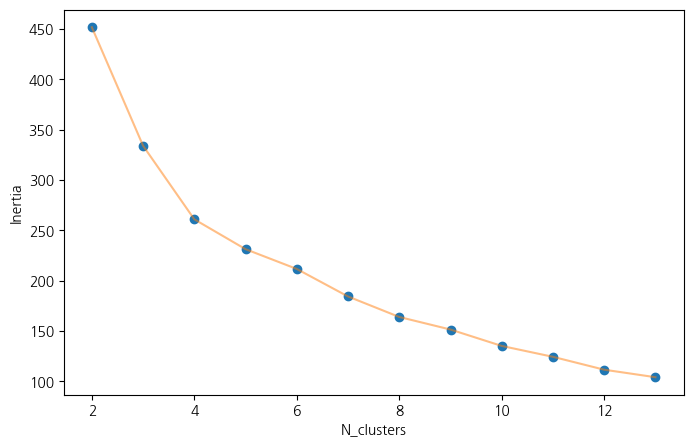

In [148]:
from sklearn.cluster import KMeans
def change_n_clusts(n_clusters, data):
    sum_of_inertia = []
    for n_cluster in n_clusters:
        kmeans = KMeans(n_clusters = n_cluster, random_state = 42)
        kmeans.fit(data)
        sum_of_inertia.append(kmeans.inertia_)

    plt.figure(1, figsize = (8, 5))
    plt.plot(n_clusters, sum_of_inertia, 'o')
    plt.plot(n_clusters, sum_of_inertia, '-', alpha = 0.5)
    plt.xlabel('N_clusters')
    plt.ylabel('Inertia')

change_n_clusts([2,3,4,5,6,7,8,9,10,11,12,13], df.iloc[:,1:])

In [149]:
kmeans = KMeans(n_clusters = 4, random_state = 42)
k_cluster = kmeans.fit_predict(df.iloc[:,1:])
print(k_cluster)

[1 0 0 3 1 0 0 0 1 3 3 3 0 0 0 0 0 0 2 2 2 0 0 0 0 0 0 3 3 3 0 0 0 1 0 3 0
 0 0 3 3 3 0 0 0 0 0 0 2 2 2 0 0 0 0 0 0 0 3 3]


In [150]:
print(np.unique(k_cluster, return_counts = True))

(array([0, 1, 2, 3], dtype=int32), array([37,  4,  6, 13]))


In [151]:
df_clust = df.copy()
df_clust['km_cluster'] = k_cluster
df_clust['km_cluster'] = df_clust['km_cluster'].map({0:1, 1:4, 2:3, 3:2})

In [152]:
match = df_clust[['num','km_cluster']]
clust_to_num = {1:[],2:[],3:[],4:[]}
for i in range(60):
    c = match.iloc[i,1]
    clust_to_num[c].append(i+1)

In [153]:
eda_df = eda_df.merge(df_clust[['num','km_cluster']], on = 'num', how = 'left')
test = test.merge(df_clust[['num','km_cluster']], on = 'num', how = 'left')

In [154]:
group = eda_df.groupby('km_cluster')

## 3-3. 각 건물별 정상성 검증(ADF)

In [155]:
from statsmodels.tsa.stattools import adfuller

# 'num' 컬럼의 각 값(건물 번호)에 대해 반복
for num in eda_df['num'].unique():
    # 특정 'num'(건물 번호)에 해당하는 데이터만 선택
    building_data = eda_df[eda_df['num'] == num]['전력사용량(kWh)']
    
    # ADF 테스트 수행
    result = adfuller(building_data)
    
    print(f'ADF Statistic for Building {num}: {result[0]}')
    print(f'p-value for Building {num}: {result[1]}')
    print('---'*20)

ADF Statistic for Building 1: -4.197988215716155
p-value for Building 1: 0.0006640859404979773
------------------------------------------------------------
ADF Statistic for Building 2: -6.218071940057246
p-value for Building 2: 5.305503447076928e-08
------------------------------------------------------------
ADF Statistic for Building 3: -2.4989319118794784
p-value for Building 3: 0.11573441846998678
------------------------------------------------------------
ADF Statistic for Building 4: -3.6274673710666705
p-value for Building 4: 0.005257108947957776
------------------------------------------------------------
ADF Statistic for Building 5: -5.980082942769443
p-value for Building 5: 1.847422852624114e-07
------------------------------------------------------------
ADF Statistic for Building 6: -6.536415983036107
p-value for Building 6: 9.583867481414604e-09
------------------------------------------------------------
ADF Statistic for Building 7: -7.302252940381075
p-value for Buil

In [156]:
## 3,11,19,20,21,28,29,30,36,49,50,51,59,60번 건물들에서 pvalue 0.05 기준 ADF를 충족하지 않음(더 차분할 필요성)

In [157]:
# buildings_to_diff = [3, 11, 19, 20, 21, 28, 29, 30, 36, 49, 50, 51, 59, 60]

In [158]:
# for building_id in buildings_to_diff:
#     # 특정 건물 ID로 데이터를 필터링
#     mask = eda_df['num'] == building_id
    
#     # 차분 적용
#     eda_df.loc[mask, '전력사용량(kWh)'] = eda_df.loc[mask, '전력사용량(kWh)'].diff()

# 4. 군집별 EDA

In [160]:
## cluster1 보면 주말에 사용량 줄고 주간에 사용량 높고 저녁, 새벽에 사용량 적다
## cluster2 보면 주말에 오히려 사용량 늘고 주간에 사용량 높고, 새벽과 저녁에 사용량 적은데 cluster0보다는 낙폭이 작다
## (아마 식당?, 카페?, 마트?, 백화점? ,가족 단위로 많이 오는 건물??)
## cluster3 보면 주말에 사용량 늘고 야간에 사용량이 는다
## cluster4 보면 주말에 사용량 줄고 시간대별로는 별 다른 패턴이 안보임

In [161]:
# cluster 1
# 평일 8-20시에 전력 사용량이 많고, 주말에 전력 사용량이 작다.
# 일반 기업체나 학교로 추정할 수 있다.

# cluster 2
# 매일 8-20시에 전력 사용량이 크다.
# 늘 전력을 소비하는 식당, 카페, 상점, 대형 복합 쇼핑몰이라고 추정할 수 있다.

# cluster 3
# 매일 저녁 16-22시에 전력 사용량이 크다.
# 평일보단 주말에 소모량이 약간 더 많다.
# 저녁과 밤 위주로 운영되는 주점, 유흥시설이라고 추정할 수 있다.

# cluster 4
# 뚜렷하게 드러나는 특징은 없지만 상대적으로 오후나 저녁 시간대에 많은 전력을 사용한다.

In [162]:
## cluster 3에서의 평균전력 사용량이 가장 높다

In [163]:
## 건물군집별 각 기온 변수들과 타겟간의 스피어만 상관계수 시각화
## 지금 각 기온 변수와 전력사용량이 선형적이지 않음
from scipy.stats import spearmanr

In [164]:
# cluster_1

df_1 = eda_df[eda_df['km_cluster'] == 1]
df = df_1.groupby(['num', '날짜'])['기온(°C)','풍속(m/s)','습도(%)','일조(hr)','강수량(mm)','전력사용량(kWh)'].mean().reset_index()
corr_1 = []
for num in clust_to_num[1]:
    corr = []
    corr.append(num)
    for feat in ['기온(°C)','풍속(m/s)','습도(%)','일조(hr)','강수량(mm)']:
        corr.append(spearmanr(df.loc[df.num == num, feat], df.loc[df.num == num, '전력사용량(kWh)']).correlation)
    corr_1.append(corr)

In [165]:
# cluster_2

df_2 = eda_df[eda_df['km_cluster'] == 2]
df = df_2.groupby(['num', '날짜'])['기온(°C)','풍속(m/s)','습도(%)','일조(hr)','강수량(mm)','전력사용량(kWh)'].mean().reset_index()
corr_2 = []
for num in clust_to_num[2]:
    corr = []
    corr.append(num)
    for feat in ['기온(°C)','풍속(m/s)','습도(%)','일조(hr)','강수량(mm)']:
        corr.append(spearmanr(df.loc[df.num == num, feat], df.loc[df.num == num, '전력사용량(kWh)']).correlation)
    corr_2.append(corr)

In [166]:
# cluster_3

df_3 = eda_df[eda_df['km_cluster'] == 3]
df = df_3.groupby(['num', '날짜'])['기온(°C)','풍속(m/s)','습도(%)','일조(hr)','강수량(mm)','전력사용량(kWh)'].mean().reset_index()
corr_3 = []
for num in clust_to_num[3]:
    corr = []
    corr.append(num)
    for feat in ['기온(°C)','풍속(m/s)','습도(%)','일조(hr)','강수량(mm)']:
        corr.append(spearmanr(df.loc[df.num == num, feat], df.loc[df.num == num, '전력사용량(kWh)']).correlation)
    corr_3.append(corr)

In [167]:
# cluster_4

df_4 = eda_df[eda_df['km_cluster'] == 4]
df = df_4.groupby(['num', '날짜'])['기온(°C)','풍속(m/s)','습도(%)','일조(hr)','강수량(mm)','전력사용량(kWh)'].mean().reset_index()
corr_4 = []
for num in clust_to_num[4]:
    corr = []
    corr.append(num)
    for feat in ['기온(°C)','풍속(m/s)','습도(%)','일조(hr)','강수량(mm)']:
        corr.append(spearmanr(df.loc[df.num == num, feat], df.loc[df.num == num, '전력사용량(kWh)']).correlation)
    corr_4.append(corr)

In [168]:
corr_total = [corr_1, corr_2, corr_3, corr_4]

In [169]:
# Cluster 1
# 전체적으로 기후 요소들과 상관이 없지만 기온과 약한 양의 상관관계가 있다.
# Cluster 2
# 기온과 높은 양의 상관관계가 있으며, 다른 군집들에 비해 기후와 상관이 있는 군집임을 유추할 수 있다.
# Cluster 3
# 군집 중 기온과 가장 높은 양의 상관관계를 가지는 군집이다.
# 기온과 습도와 비교적 높은 양의 상관관계를 가진다.
# 건물마다 풍속과의 상관관계가 상이하다.
# Cluster 4
# 뚜렷한 군집 특성이 드러나지 않는다.
# 9번 건물 보면 낮보다 밤에 사용량이 많고 습도가 높고 강수가 많으면 사용량이 많음(태양광)

In [170]:
## 태양광은 낮에 발전하여 야간에 사용됨(전날 일조량과 당일 사용량을 비교해보자)

In [171]:
## 3,9,12,16,21,24,34,51,60에서 (전일일조량+오늘일조량)누적과 오늘 전력사용량간의 뚜렷한 음의 상관관계가 보임

In [172]:
# Cluster 1, Cluster 2에 cooler가 비교적 많이 설치되어 있고,
# Cluster 3에는 cooler가 설치되어 있지 않습니다.
# 주간-야간에 골고루 전력 소모량이 많은 건물들엔 설치율이 높고 야간에 전력 소모량이 많은 건물엔 설치율이 낮음

# Solar는 모든 군집에 설치
# 설치 비율을 따져본다면, 주로 밤에 전력을 소모하는 Cluster 3의 경우 설치율이 상대적으로 낮음

# Cluster 2은 cooler와 solar의 설치 비율이 높고, 그만큼 전력 사용량도 높다
# Cluster 4의 경우 cooler와 solar가 설치되지 않은 건물들에서 전력 사용량이 높습니다.

In [173]:
## 위 그래프보면 건물 9제외하고 대체로 불쾌지수가 높을수록 전력사용이 증가함

In [ ]:
mean_31 = num_31[num_31['시각'] == 17]['전력사용량(kWh)'].mean()

In [175]:
mean_33 = num_33[num_33['시각'] == 17]['전력사용량(kWh)'].mean()

In [176]:
num_31[num_31['전력사용량(kWh)']<4000]

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유,날짜,월,주,일,시각,요일,주말,월별주수,시간대,불쾌지수,체감온도,km_cluster


In [177]:
num_33[num_33['전력사용량(kWh)']<2000]

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유,날짜,월,주,일,시각,요일,주말,월별주수,시간대,불쾌지수,체감온도,km_cluster


In [178]:
eda_df.loc[(eda_df['num'] == 31) & (eda_df['전력사용량(kWh)'] < 4000), '전력사용량(kWh)'] = mean_31
eda_df.loc[(eda_df['num'] == 33) & (eda_df['전력사용량(kWh)'] < 2000), '전력사용량(kWh)'] = mean_33

In [179]:
eda_df[(eda_df['요일'] ==3) & (eda_df['시각'] == 17) & (eda_df['num'] == 31)]

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유,날짜,월,주,일,시각,요일,주말,월별주수,시간대,불쾌지수,체감온도,km_cluster
61265,31,2020-06-03 17:00:00,6018.624,28.1,3.8,49.0,0.0,1.0,1.0,0.0,2020-06-03,6,23,3,17,3,0,1,활동,75.68531,30.490530,1
61433,31,2020-06-10 17:00:00,6254.064,28.7,3.4,55.0,0.0,0.0,1.0,0.0,2020-06-10,6,24,10,17,3,0,2,활동,77.30915,30.960896,1
61601,31,2020-06-17 17:00:00,6100.272,27.6,4.1,46.0,0.0,0.1,1.0,0.0,2020-06-17,6,25,17,17,3,0,3,활동,74.64704,30.096362,1
61769,31,2020-06-24 17:00:00,5935.248,20.6,2.2,95.0,1.9,0.0,1.0,0.0,2020-06-24,6,26,24,17,3,0,4,활동,68.77530,24.720019,1
61937,31,2020-07-01 17:00:00,5926.176,24.3,1.6,68.0,0.0,0.0,1.0,0.0,2020-07-01,7,27,1,17,3,0,1,활동,72.61776,27.603050,1
62105,31,2020-07-08 17:00:00,6292.080,30.1,2.9,55.0,0.0,0.9,1.0,0.0,2020-07-08,7,28,8,17,3,0,2,활동,79.20545,32.048849,1
62273,31,2020-07-15 17:00:00,6039.792,28.6,1.8,42.0,0.0,1.0,1.0,0.0,2020-07-15,7,29,15,17,3,0,3,활동,75.35188,30.883950,1
62441,31,2020-07-22 17:00:00,6015.168,24.3,2.3,91.0,0.3,0.0,1.0,0.0,2020-07-22,7,30,22,17,3,0,4,활동,74.86187,27.566020,1
62609,31,2020-07-29 17:00:00,6145.200,24.6,1.8,96.0,0.3,0.0,1.0,0.0,2020-07-29,7,31,29,17,3,0,5,활동,75.87784,27.820989,1
62777,31,2020-08-05 17:00:00,6342.192,28.0,3.9,83.0,0.0,0.0,1.0,0.0,2020-08-05,8,32,5,17,3,0,1,활동,80.11860,30.411667,1


In [180]:
eda_df[(eda_df['요일'] ==3) & (eda_df['시각'] == 17) & (eda_df['num'] == 33)]

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유,날짜,월,주,일,시각,요일,주말,월별주수,시간대,불쾌지수,체감온도,km_cluster
65345,33,2020-06-03 17:00:00,2760.912,28.3,2.3,52.0,0.0,0.0,1.0,0.0,2020-06-03,6,23,3,17,3,0,1,활동,76.35584,30.652059,1
65513,33,2020-06-10 17:00:00,2725.272,31.8,1.7,51.0,0.0,0.4,1.0,0.0,2020-06-10,6,24,10,17,3,0,2,활동,80.82082,33.330217,1
65681,33,2020-06-17 17:00:00,2657.016,25.5,1.6,61.0,0.0,0.0,1.0,0.0,2020-06-17,6,25,17,17,3,0,3,활동,73.63145,28.518707,1
65849,33,2020-06-24 17:00:00,2606.472,21.8,3.4,94.0,0.1,0.0,1.0,0.0,2020-06-24,6,26,24,17,3,0,4,활동,70.80308,25.570680,1
66017,33,2020-07-01 17:00:00,2635.848,23.7,1.4,73.0,0.0,0.0,1.0,0.0,2020-07-01,7,27,1,17,3,0,1,활동,72.18599,27.160110,1
66185,33,2020-07-08 17:00:00,2724.624,29.8,1.0,64.0,0.0,1.0,1.0,0.0,2020-07-08,7,28,8,17,3,0,2,활동,80.16728,31.788285,1
66353,33,2020-07-15 17:00:00,2632.392,24.5,0.0,77.0,0.0,0.2,1.0,0.0,2020-07-15,7,29,15,17,3,0,3,활동,73.81035,28.346750,1
66521,33,2020-07-22 17:00:00,2655.504,24.1,2.3,90.0,0.0,0.0,1.0,0.0,2020-07-22,7,30,22,17,3,0,4,활동,74.42410,27.411718,1
66689,33,2020-07-29 17:00:00,2665.224,26.1,0.6,97.0,0.0,0.0,1.0,0.0,2020-07-29,7,31,29,17,3,0,5,활동,78.63383,29.029492,1
66857,33,2020-08-05 17:00:00,2745.144,27.4,1.5,97.0,0.7,0.4,1.0,0.0,2020-08-05,8,32,5,17,3,0,1,활동,80.93522,29.970353,1


In [184]:
eda_df = pd.get_dummies(eda_df, columns=['시간대'])
test = pd.get_dummies(test, columns=['시간대'])


In [185]:
test = test.rename({'강수량(mm, 6시간)':'강수량(mm)', '일조(hr, 3시간)':'일조(hr)'},axis=1)

# 5. 오토아리마 모델설정

In [187]:
sub = pd.read_csv('sample_submission.csv', encoding='cp949')

In [188]:
%matplotlib inline

import matplotlib as mpl  # 기본 설정
import matplotlib.pyplot as plt  # 그래프 그리기
import matplotlib.font_manager as fm  # 폰트 관리


!apt-get update -qq         # apt-get 패키지 설치 명령어, -qq : 에러외 메세지 숨기기
!apt-get install fonts-nanum* -qq #나눔글꼴 설치

fe = fm.FontEntry(fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', name='NanumGothic') #파일 저장되어있는 경로와 이름 설정
fm.fontManager.ttflist.insert(0, fe)  # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumGothic'}) #폰트설정
mpl.rcParams['axes.unicode_minus'] = False

E: Could not open lock file /var/lib/apt/lists/lock - open (13: Permission denied)
E: Unable to lock directory /var/lib/apt/lists/
E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [189]:
!pip install tslearn
!pip install minisom
!pip install koreanize-matplotlib
!pip install pmdarima

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [190]:
import pandas as pd
import numpy as np
import math
import koreanize_matplotlib
from pmdarima.arima import ndiffs
import pmdarima as pm

#Visualizing
import matplotlib.pyplot as plt
# plt.rcParams['font.family'] = 'Malgun Gothic'; plt.rcParams['axes.unicode_minus'] = False;
import seaborn as sns; #sns.set_style('whitegrid')

#Time Series Analysis
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss, ccf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#Clustering (+α)
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from minisom import MiniSom

#Modeling
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

#System
from ipywidgets import interact
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

2023-11-01 14:03:57.223490: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-01 14:03:57.260643: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-01 14:03:57.260692: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-01 14:03:57.260720: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-01 14:03:57.267142: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-01 14:03:57.267894: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [191]:
eda_df.set_index('date_time',inplace=True)

In [192]:
eda_df[eda_df['전력사용량(kWh)'].isna()]['num'].unique()

array([], dtype=int64)

In [193]:
building_ids = [3, 11, 19, 20, 21, 28, 29, 30, 36, 49, 50, 51, 59, 60]
average_power_usage = {}
# 건물 번호와 시간을 기준으로 데이터를 필터링합니다.
filtered_df = eda_df[(eda_df['num'].isin(building_ids)) & (eda_df['시각'] == 0)]

average_power_usage = filtered_df.groupby(['num', '시각'])['전력사용량(kWh)'].mean()

In [194]:
a = list(average_power_usage)

In [195]:
building_ids = [3, 11, 19, 20, 21, 28, 29, 30, 36, 49, 50, 51, 59, 60]
for r,i in enumerate(building_ids):
    eda_df.loc[(eda_df['num'] == i) & (eda_df['전력사용량(kWh)'].isna()),'전력사용량(kWh)'] = a[r]

In [197]:
# 건물 나누기
df_dict = {}
for i in range(1,61) :
    df_dict[i] = eda_df[eda_df['num'] == i]

df_dict[3]

,num,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유,날짜,월,주,일,시각,요일,주말,월별주수,불쾌지수,체감온도,km_cluster,냉방도일,시간대_아침,시간대_저녁,시간대_취침,시간대_활동
date_time,,,,,,,,,,,,,,,,,,,,,,,,,
2020-06-01 00:00:00,3,3233.903627,17.0,2.0,100.0,1.1,0.0,1.0,1.0,2020-06-01,6,23,1,0,1,0,1,62.60000,21.972731,1,-4.9,0,0,1,0
2020-06-01 01:00:00,3,3233.903627,17.2,2.3,99.0,0.1,0.0,1.0,1.0,2020-06-01,6,23,1,1,1,0,1,62.93272,22.088300,1,-4.9,0,0,1,0
2020-06-01 02:00:00,3,3233.903627,17.2,3.7,98.0,0.0,0.0,1.0,1.0,2020-06-01,6,23,1,2,1,0,1,62.90544,21.952240,1,-4.9,0,0,1,0
2020-06-01 03:00:00,3,3233.903627,16.7,3.1,99.0,0.0,0.0,1.0,1.0,2020-06-01,6,23,1,3,1,0,1,62.03767,21.614665,1,-4.9,0,0,1,0
2020-06-01 04:00:00,3,3233.903627,16.9,3.5,98.0,0.0,0.0,1.0,1.0,2020-06-01,6,23,1,4,1,0,1,62.37138,21.734103,1,-4.9,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-24 19:00:00,3,3572.334982,29.2,1.0,72.0,0.0,0.6,1.0,1.0,2020-08-24,8,35,24,19,1,0,4,80.46976,31.336609,1,3.1,0,1,0,0
2020-08-24 20:00:00,3,3571.432457,28.0,0.1,79.0,0.0,0.0,1.0,1.0,2020-08-24,8,35,24,20,1,0,4,79.58180,30.460605,1,3.1,0,1,0,0
2020-08-24 21:00:00,3,3569.301794,27.6,0.1,82.0,0.0,0.0,1.0,1.0,2020-08-24,8,35,24,21,1,0,4,79.33568,30.175672,1,3.1,0,1,0,0


In [198]:
# 건물 나누기
test_dict = {}
for i in range(1,61) :
    test_dict[i] = test[test['num'] == i].reset_index(drop = True)

test_dict[1]

,num,date_time,기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유,날짜,월,주,일,시각,요일,주말,월별주수,불쾌지수,체감온도,km_cluster,냉방도일,시간대_아침,시간대_저녁,시간대_취침,시간대_활동
0,1,2020-08-25 00:00:00,27.800000,1.500000,74.000000,0.0,0.0,0.0,0.0,2020-08-25,8,35,25,0,2,0,4,78.602280,30.274990,4,6.25,0,0,1,0
1,1,2020-08-25 01:00:00,27.633333,1.366667,75.333333,0.0,0.0,0.0,0.0,2020-08-25,8,35,25,1,2,0,4,78.519273,30.150217,4,6.25,0,0,1,0
2,1,2020-08-25 02:00:00,27.466667,1.233333,76.666667,0.0,0.0,0.0,0.0,2020-08-25,8,35,25,2,2,0,4,78.431867,30.026349,4,6.25,0,0,1,0
3,1,2020-08-25 03:00:00,27.300000,1.100000,78.000000,0.0,0.0,0.0,0.0,2020-08-25,8,35,25,3,2,0,4,78.340060,29.903525,4,6.25,0,0,1,0
4,1,2020-08-25 04:00:00,26.900000,1.166667,79.666667,0.0,0.0,0.0,0.0,2020-08-25,8,35,25,4,2,0,4,77.912697,29.599362,4,6.25,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,1,2020-08-31 19:00:00,28.233333,2.800000,72.666667,0.0,0.8,0.0,0.0,2020-08-31,8,36,31,19,1,0,5,79.088727,30.598502,4,2.55,0,1,0,0
164,1,2020-08-31 20:00:00,27.666667,2.600000,73.333333,0.0,0.4,0.0,0.0,2020-08-31,8,36,31,20,1,0,5,78.309333,30.160437,4,2.55,0,1,0,0
165,1,2020-08-31 21:00:00,27.100000,2.400000,74.000000,0.0,0.0,0.0,0.0,2020-08-31,8,36,31,21,1,0,5,77.522460,29.724632,4,2.55,0,1,0,0
166,1,2020-08-31 22:00:00,26.966667,1.900000,78.333333,0.0,0.0,0.0,0.0,2020-08-31,8,36,31,22,1,0,5,77.853983,29.631099,4,2.55,0,1,0,0


In [199]:
import pmdarima as pm
import statsmodels.api as sm
def process_data(x):
    plt.figure(figsize=(10, 5))
    y_train = df_dict[x]['전력사용량(kWh)'][:int(0.8 * len(df_dict[x]))]
    y_test = df_dict[x]['전력사용량(kWh)'][int(0.8 * len(df_dict[x])):]
    y_train.index = pd.to_datetime(y_train.index)
    y_test.index = pd.to_datetime(y_test.index)

    y_train.plot()
    y_test.plot()
    plt.suptitle('전력사용량(kWh)')
    plt.show()

    result = seasonal_decompose(df_dict[x]['전력사용량(kWh)'], model='additive', period=85)

    fig = plt.figure()
    fig = result.plot()
    fig.set_size_inches(10, 10)

    fig = plt.figure(figsize=(10, 5))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(df_dict[x]['전력사용량(kWh)'], lags=85, ax=ax1)

    result = adfuller(df_dict[x]['전력사용량(kWh)'])
    if result[1] < 0.05:
        print('ADF Stats: %f' % result[0])
        print('P val:', result[1])
        print('Critical Values:')
        for i, v in result[4].items():
            print(i, v)
    else:
        kpss_diffs = ndiffs(y_train, alpha=0.05, test='kpss', max_d=6)
        adf_diffs = ndiffs(y_train, alpha=0.05, test='adf', max_d=6)
        n_diffs = max(adf_diffs, kpss_diffs)
        diff = df_dict[x]['전력사용량(kWh)'] - df_dict[x]['전력사용량(kWh)'].shift()
        result = adfuller(diff[1:])
        print('ADF Stats: %f' % result[0])
        print('P val: %f' % result[1])
        print('Critical Values:')
        for i, v in result[4].items():
            print(i, v)

    stepwise_model = pm.auto_arima(y_train,
                                   d=1,
                                   start_p=0,
                                   start_q=0,
                                   max_p=7,
                                   max_q=7,
                                   seasonal=False,
                                   suppress_warnings=True,
                                   stepwise=False)
    stepwise_model.fit(y_train)
    stepwise_model.plot_diagnostics(figsize=(16, 8))
    plt.show()

    # 테스트 데이터 개수만큼 예측
    y_predict = stepwise_model.predict(n_periods=len(y_test))
    y_predict = pd.DataFrame(y_predict, index=y_test.index, columns=['Prediction'])

    # 그래프
    fig, axes = plt.subplots(1, 1, figsize=(12, 4))
    plt.plot(y_train, label='Train')        # 훈련 데이터
    plt.plot(y_test, label='Test')          # 테스트 데이터
    plt.plot(y_predict, label='Prediction')  # 예측 데이터
    plt.legend()
    plt.show()

In [200]:
# # df_dict[x] 데이터를 처리하는 함수 호출
# for i in range(1,61) :
#   print(f'buliding_num:{i}')
#   process_data(i)

## ###################################################################

<Figure size 1000x500 with 0 Axes>

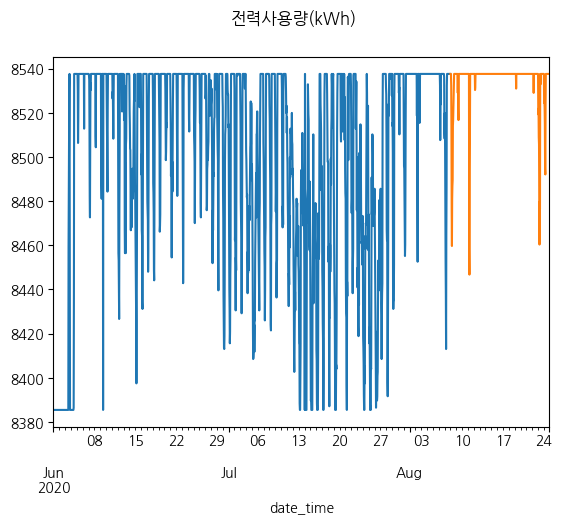

In [201]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
y_train = df_dict[1]['전력사용량(kWh)'][:int(0.8 * len(df_dict[1]))]
y_test = df_dict[1]['전력사용량(kWh)'][int(0.8 * len(df_dict[1])):]
y_train.index = pd.to_datetime(y_train.index)
y_test.index = pd.to_datetime(y_test.index)
fig = plt.figure()  # Create a new figure object

y_train.plot()
y_test.plot()
fig.suptitle('전력사용량(kWh)')
plt.show()

<Figure size 640x480 with 0 Axes>

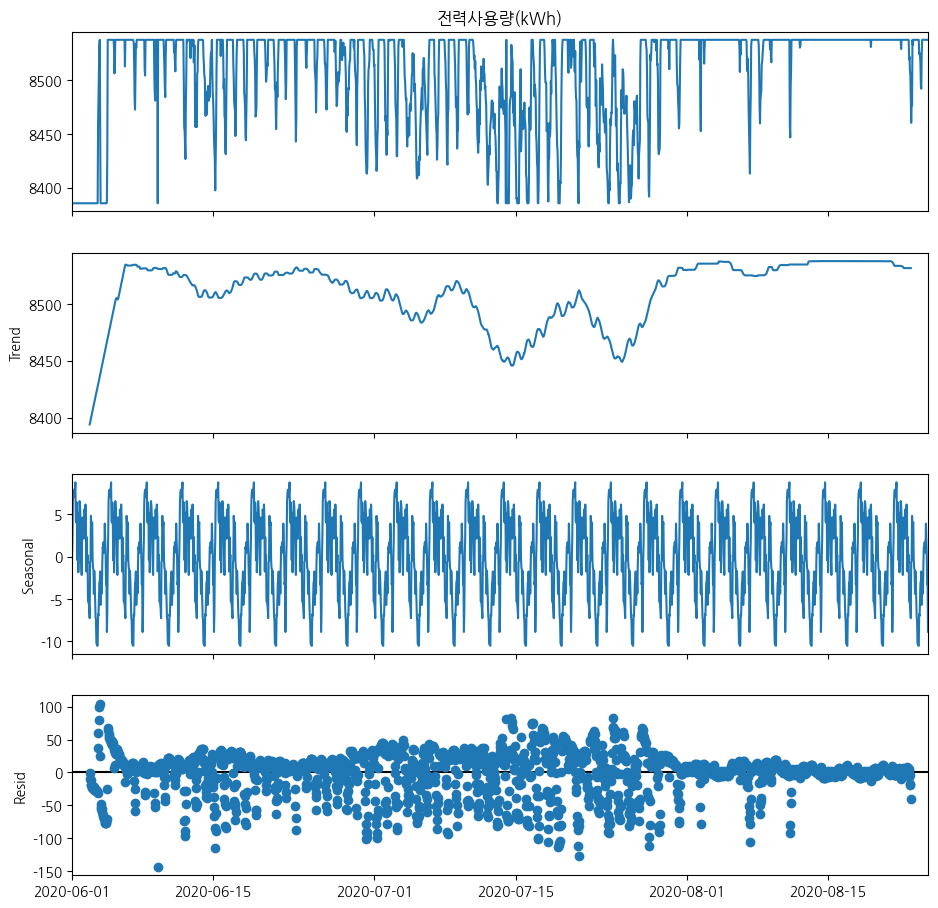

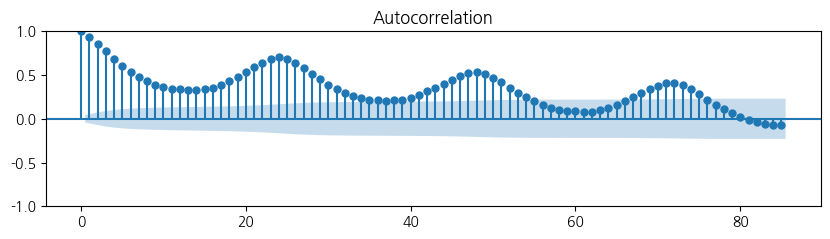

In [202]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df_dict[1]['전력사용량(kWh)'],
                            model = 'additive',
                            period = 85) # 하루24, 매일85

fig = plt.figure()
fig = result.plot()
fig.set_size_inches(10,10)

import statsmodels.api as sm

fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_dict[1]['전력사용량(kWh)'], lags = 85, ax = ax1)

In [203]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df_dict[1]['전력사용량(kWh)'])
if result[1]<0.05:
  print('ADF Stats : %f' % result[0])
  print('P val :',result[1])
  print('Critical Values : ')
  for i, v in result[4].items():
    print(i,v)
else:
  kpss_diffs = ndiffs(y_train, alpha=0.05, test='kpss', max_d=6)
  adf_diffs = ndiffs(y_train, alpha=0.05, test='adf', max_d=6)
  n_diffs = max(adf_diffs, kpss_diffs)
  diff = df_dict[1]['전력사용량(kWh)'] - df_dict[1]['전력사용량(kWh)'].shift()
  result = adfuller(diff[1:])
  print('ADF Stats : %f' % result[0])
  print('P val : %f' % result[1])
  print('Critical Values : ')
  for i, v in result[4].items():
    print(i,v)

ADF Stats : -4.197988
P val : 0.0006640859404979773
Critical Values : 
1% -3.4336026867364144
5% -2.8629768669694458
10% -2.5675349256978177


<!-- ADF를 진행해본결과 p값이 0.05보다 작기 때문에 귀무가설을 기각할 수 있습니다.
ADF를 진행해본결과 p값이 0.05를 넘기때문에 귀무가설을 기각하지 못하게 됩니다. -->

In [204]:
stepwise_model = pm.auto_arima(y_train,d = 1, start_p = 0,start_q = 0,max_p = 7,max_q = 7,seasonal=False,suppress_warnings=True,stepwise=False)
stepwise_model.fit(y_train)

ARIMA(order=(2, 1, 3), scoring_args={}, suppress_warnings=True)

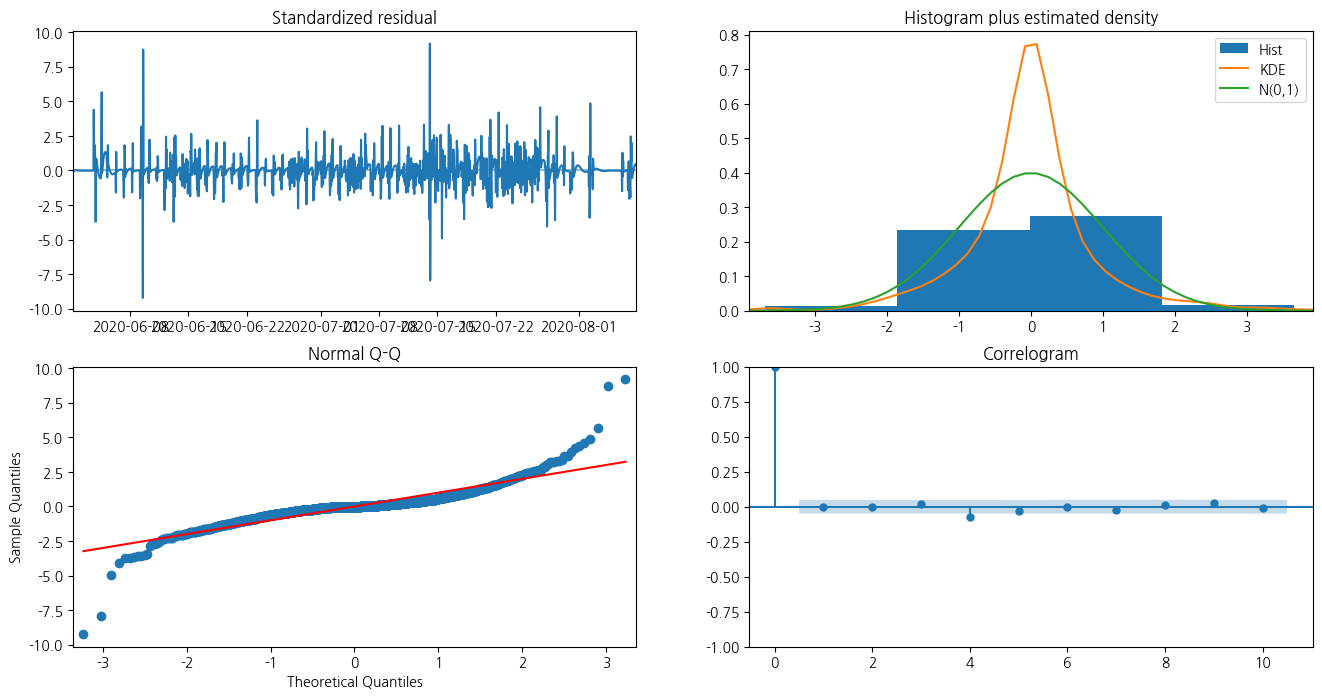

In [205]:
stepwise_model.plot_diagnostics(figsize=(16, 8))
plt.show()

In [206]:
# for i in range(1,61):
#     process_data(i)

## 5-1 검증 데이터

In [207]:
x_sub = df_dict[1]['전력사용량(kWh)'][:int(0.8 * len(df_dict[1]))]
x_val = df_dict[1]['전력사용량(kWh)'][int(0.8 * len(df_dict[1])):]
x_sub.index = pd.to_datetime(x_sub.index)
x_val.index = pd.to_datetime(x_val.index)

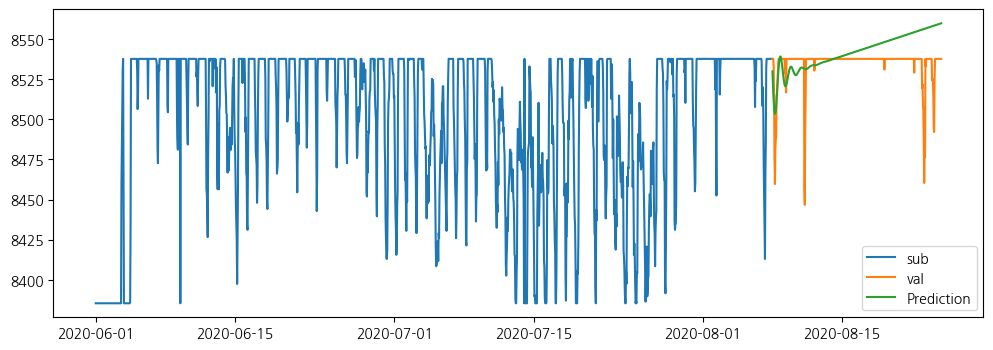

In [208]:
# 테스트 데이터 개수만큼 예측

y_predict = stepwise_model.predict(n_periods=len(x_val))
y_predict = pd.DataFrame(y_predict,index = y_predict.index,columns=['Prediction'])

# 그래프
fig, axes = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(y_train, label='sub')        # 훈련 데이터
plt.plot(y_test, label='val')          # 테스트 데이터
plt.plot(y_predict, label='Prediction')  # 예측 데이터
plt.legend()
plt.show()

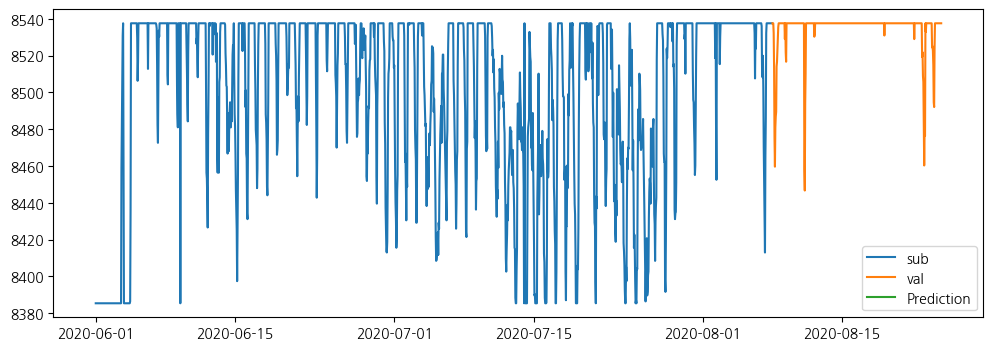

In [209]:
# 테스트 데이터 개수만큼 예측
y_predict = stepwise_model.predict(n_periods=len(x_sub))
y_predict = pd.DataFrame(y_predict,index = x_sub.index,columns=['Prediction'])

# 그래프
# 테스트 데이터 개수만큼 예측
fig, axes = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(y_train, label='sub')        # 훈련 데이터
plt.plot(y_test, label='val')          # 테스트 데이터
plt.plot(y_predict, label='Prediction')  # 예측 데이터
plt.legend()
plt.show()

## 5-2 테스트 데이터

In [210]:
for i in range(1,61):
    test_dict[i] = test_dict[i].set_index('date_time')

In [211]:
df_dict[1]['전력사용량(kWh)']

date_time
2020-06-01 00:00:00    8385.40512
2020-06-01 01:00:00    8385.40512
2020-06-01 02:00:00    8385.40512
2020-06-01 03:00:00    8385.40512
2020-06-01 04:00:00    8385.40512
                          ...    
2020-08-24 19:00:00    8537.56200
2020-08-24 20:00:00    8537.56200
2020-08-24 21:00:00    8537.56200
2020-08-24 22:00:00    8537.56200
2020-08-24 23:00:00    8537.56200
Name: 전력사용량(kWh), Length: 2040, dtype: float64

In [212]:
# 건물 나누기
df_dict = {}
for i in range(1,61) :
    df_dict[i] = eda_df[eda_df['num'] == i]


In [213]:
chaboon = [3, 11, 19, 20, 21, 28, 29, 30, 36, 49, 50, 51, 59, 60]

In [214]:
n_predict = {}
for i in chaboon:
    new_train = df_dict[i]['전력사용량(kWh)']
    new_train.index = pd.to_datetime(new_train.index)
    
    stepwise_model = pm.auto_arima(new_train,
                                       m=24,
                                       d=1,
                                       start_p=0,
                                       start_q=0,
                                       max_p=7,
                                       max_q=7,
                                       seasonal=False,
                                       suppress_warnings=True,
                                       stepwise=False)
    
    n_predict[i] = stepwise_model.predict(n_periods=168)
    n_predict[i] = pd.DataFrame(n_predict[i], columns=['Prediction'])

In [215]:
a=list(set(range(1,61))-set(chaboon))

In [216]:
n2_predict = {}
for i in a:
    new_train = df_dict[i]['전력사용량(kWh)']
    new_train.index = pd.to_datetime(new_train.index)
    
    stepwise_model = pm.auto_arima(new_train,
                                       m=24,
                                       
                                       start_p=0,
                                       start_q=0,
                                       max_p=7,
                                       max_q=7,
                                       seasonal=False,
                                       suppress_warnings=True,
                                       stepwise=False)
    
    n2_predict[i] = stepwise_model.predict(n_periods=168)
    n2_predict[i] = pd.DataFrame(n2_predict[i], columns=['Prediction'])


KeyboardInterrupt



In [ ]:
merged_dict = {**n_predict, **n2_predict}


In [ ]:
# 키 값에 따라 오름차순으로 정렬
sorted_keys = sorted(merged_dict.keys())

# 정렬된 키 값에 따라 데이터프레임을 병합
merged_df = pd.concat([merged_dict[key] for key in sorted_keys])

In [ ]:
merged_df

In [ ]:
## 각 건물에 대해 ADF수행한 결과 p-value가 0.05보다 작아서 정상성을 충족한다.
## 즉 각 건물의 시계열 데이터에 단위근이 존재하지 않는다는 것
## critical value는 일반적으로 1%, 5%, 10%의 세 가지 유의수준에서 제공됩니다.
## 각각의 유의수준은 귀무 가설을 기각하기 위한 임계값을 나타냅니다.
## 예를 들어, 5%의 critical value는 귀무 가설을 5%의 오류 확률로 기각하는 임계값을 의미합니다.
## 따라서, ADF 검증을 수행할 때 ADF 통계치를 critical value와 비교하여 시계열 데이터가 정상인지 비정상인지를 결정합니다.
## ADF 통계치가 critical value보다 작으면, 해당 유의수준에서 시계열 데이터는 정상으로 판단합니다.

In [ ]:
# P-value는 귀무 가설이 참일 경우에 관찰된 검정 통계량(또는 더 극단적인 검정 통계량)을 얻을 확률을 나타냅니다.
# P-value가 0.05보다 작으면, 귀무 가설을 5%의 오류 수준에서 기각합니다. 
# 이는 ADF 테스트에서 귀무 가설이 시계열 데이터가 비정상적임을 주장하므로, 
# p-value가 0.05보다 작다는 것은 시계열이 정상적이라는 대립 가설을 채택하게 됩니다.

# 따라서, ADF 테스트에서 Critical Value 5% 수준은 검정 통계량의 임계값을 나타내며, 
# p-value 0.05는 해당 임계값에서 귀무 가설을 기각하는 기준을 나타냅니다. 
# P-value와 Critical Value는 모두 귀무 가설을 기각할지 여부를 결정하는 데 사용되지만, 그 방법과 해석은 약간 다릅니다.

In [ ]:
sub

In [ ]:
merged_df = merged_df.reset_index()

In [ ]:
sub['answer'] = merged_df['Prediction']

In [ ]:
sub

In [ ]:
sub.to_csv('baseline_.csv', index = False, encoding='utf-8')

In [ ]:
sub

In [ ]:
## SMAPE가 40점이상으로 매우높음